generate trafficfiles
copy from makeflowfiles/makec2s.ipynb

In [20]:
# parameters
c = 64
s = 4
numleaf = 64
# multlistarr = [[0,69,160],[0,69,80],[1,47,160],[1,29,40],[2,5,32],[2,47,80],[3,3,160]]
multlistarr = [[0,69,320],[0,207,320],[1,5,64],[1,163,320],[1,301,320]]
seed = 0
numserver = 3072
numsw = 80
numport = 64


# read leafspine serverfile
serverfile = f"/home/annzhou/DRing/src/emp/datacentre/serverfiles/leafspine_{numserver}_{numsw}_{numport}"
serverdict = dict()
with open(serverfile,'r') as f:
    lines = f.readlines()
    for line in lines:
        tokens = line.split(',')
        serverdict[int(tokens[0])] = int(tokens[1])


import numpy as np
import random
random.seed(seed)

# inspired by int ConnectionMatrix::genFlowBytes()
def genflowbytes():
    mean_bytes = 100.0 * 1024
    shape = 1.05
    scale = mean_bytes * (shape - 1)/shape

    x = np.random.exponential(scale=1.0/shape)
    flowbytes = int(scale * np.exp(x))
    return flowbytes

def adjustbytesbymtu(flowbytes):
  mss = 1500
  return mss * ((flowbytes+mss-1)//mss)


for multlist in multlistarr:
    mult = multlist[0]
    numerator = multlist[1]
    denominator = multlist[2]
    
    allfromswitches = list()
    alltoswitches = list()
    if c==numleaf:
        allfromswitches = range(numleaf)
    else:
        while len(allfromswitches)<c:
            rsw = random.randint(0,numleaf-1)
            if rsw not in allfromswitches:
                allfromswitches.append(rsw)
    if s==numleaf:
        alltoswitches = range(numleaf)
    else:
        while len(alltoswitches)<s:
            rsw = random.randint(0,numleaf-1)
            if rsw not in alltoswitches:
                alltoswitches.append(rsw)

    allfromservers = list()
    alltoservers = list()
    for lsserver in range(numserver):
        lsswitch = serverdict[lsserver]
        if lsswitch in allfromswitches:
            allfromservers.append(lsserver)
        if lsswitch in alltoswitches:
            alltoservers.append(lsserver)

    large_flow_threshold = 10 * 1024 * 1024
    base_flows = list()
    for fromsvr in allfromservers:
        for tosvr in alltoservers:
            if fromsvr!=tosvr:
                mybytes = genflowbytes()
                while mybytes<0 or mybytes>large_flow_threshold:
                    mybytes = genflowbytes()
                mybytes = adjustbytesbymtu(mybytes)
                base_flows.append([fromsvr,tosvr,mybytes])

    flowfile = f"/home/annzhou/DRing/src/emp/datacentre/flowfiles/c2s_{c}_{s}_{mult}_{numerator}_{denominator}_{seed}"
    with open(flowfile,'w') as f:
        if mult>0:
            for m in range(mult):
                for flow in base_flows:
                    f.write(f"{flow[0]},{flow[1]},{flow[2]}\n")

        if denominator>0:
            for flow in base_flows:
                r = random.randint(0,denominator-1) # inclusive
                if r<numerator:
                    f.write(f"{flow[0]},{flow[1]},{flow[2]}\n")

generate pathweightfiles
copy from makepathweightfiles/makepathweightfiles.ipynb

In [21]:
# set parameters
numfaillinkarr = [0,43]
fseedarr = range(5)
# multstrarr = ["0_69_160","0_69_80","1_47_160","1_29_40","2_5_32","2_47_80","3_3_160"]
multstrarr = ["0_69_320","0_207_320","1_5_64","1_163_320","1_301_320"]

graphname = "dring"
routingname = "32disjoint"
pwname = ""
numsw = 80
numport = 64
numserver = 2988
numlink = 2132
homedir = "/home/annzhou"

c=64
s=4
tseed = 0

method = 2
crossover = 0
factor = 64

for multstr in multstrarr:
    for numfaillink in numfaillinkarr:
        if numfaillink==0:
            myfseedarr = [0]
        else:
            myfseedarr = fseedarr
        for fseed in myfseedarr:
            print(f"multstr: {multstr}, numfaillink={numfaillink}, fseed={fseed}")

            trafficname = f"c2s_{c}_{s}_{tseed}_{multstr}"
            flowfile = f"{homedir}/DRing/src/emp/datacentre/flowfiles/c2s_{c}_{s}_{multstr}_{tseed}"

            if graphname=="dring" or graphname=="rrg":
                netpathfile = f"{homedir}/DRing/src/emp/datacentre/netpathfiles/netpath_{routingname}_{graphname}.txt"
            else:
                print("ERROR: leafspine does not need to compute path weight")

            if graphname=="dring":
                graphfile = f"{homedir}/DRing/src/emp/datacentre/graphfiles/ring_supergraph/double_ring/instance1_{numsw}_{numport}.edgelist"
            elif graphname=="rrg":
                graphfile = f"{homedir}/DRing/src/emp/datacentre/graphfiles/ring_supergraph/rrg/instance1_{numsw}_{numport}.edgelist"
            else:
                print("ERROR: leafspine does not need to compute path weight")

            linkfailurefile = f"{homedir}/DRing/src/emp/datacentre/linkfailurefiles/{graphname}_{numlink}_{numfaillink}_{fseed}"

            serverfile = f"{homedir}/DRing/src/emp/datacentre/serverfiles/{graphname}_{numserver}_{numsw}_{numport}"

            tag = f"{graphname}_{numfaillink}_{fseed}_{routingname}_{trafficname}_{method}_{crossover}_{factor}"
            varfile = f"{homedir}/DRing/src/emp/datacentre/qvarfiles/var_{tag}"
            qvarfile = f"{homedir}/DRing/src/emp/datacentre/qvarfiles/qvar_{tag}"
            modelfile = f"{homedir}/DRing/src/emp/datacentre/makepathweightfiles/model.lp"


            # read netpathfile
            netpath = list()
            for i in range(numsw):
                netpath.append(list())
                for j in range(numsw):
                    netpath[i].append(list())
            with open(netpathfile,'r') as f:
                lines = f.readlines()
                # produce
                fromsw = 0
                tosw = 0
                for line in lines:
                    if "->" not in line:
                        tokens = line.split()
                        fromsw = int(tokens[0])
                        tosw = int(tokens[1])
                    else:
                        path = [fromsw]
                        tokens = line.split()
                        for token in tokens:
                            hops = token.split("->")
                            path.append(int(hops[1]))
                        netpath[fromsw][tosw].append(path)

                # check
                for line in lines:
                    if "->" not in line:
                        tokens = line.split()
                        fromsw = int(tokens[0])
                        tosw = int(tokens[1])
                        numpaths = int(tokens[2])
                        if len(netpath[fromsw][tosw])!=numpaths:
                            print(f"ERROR: netpath is wrong, fromsw={fromsw}, tosw={tosw}, numpaths from file={numpaths}, numpaths from array={len(netpath[fromsw][tosw])}")

            # read graphfile
            link = list()
            for i in range(numsw):
                link.append(list())
                for j in range(numsw):
                    link[i].append(0)
            with open(graphfile,'r') as f:
                lines = f.readlines()
                for line in lines:
                    tokens = line.split("->")
                    fromsw = int(tokens[0])
                    tosw = int(tokens[1])
                    link[fromsw][tosw] = 1
                    link[tosw][fromsw] = 1

            # read linkfailurefile (if needed)
            if numfaillink > 0:
                with open(linkfailurefile,'r') as f:
                    lines = f.readlines()
                    for line in lines:
                        tokens = line.split()
                        fromsw = int(tokens[0])
                        tosw = int(tokens[1])
                        if link[fromsw][tosw] != 1:
                            print(f"ERROR: should have a link from {fromsw} to {tosw} but not")
                        else:
                            link[fromsw][tosw] /= 2

            # read serverfile
            serverdict = dict()
            with open(serverfile,'r') as f:
                lines = f.readlines()
                for line in lines:
                    tokens = line.split(',')
                    serverdict[int(tokens[0])] = int(tokens[1])

            # read flowfile
            traffic = list()
            for i in range(numsw):
                traffic.append(list())
                for j in range(numsw):
                    traffic[i].append(0)
            with open(flowfile,'r') as f:
                lines = f.readlines()
                for line in lines:
                    tokens = line.split(",")
                    fromsvr = int(tokens[0])
                    tosvr = int(tokens[1])
                    if fromsvr>=numserver or tosvr>=numserver: continue
                    fromsw = serverdict[fromsvr]
                    tosw = serverdict[tosvr]
                    if fromsw == tosw: continue
                    flowbytes = int(tokens[2])
                    traffic[fromsw][tosw] += flowbytes


            # precompute
            flowsvialink = list()
            for i in range(numsw):
                flowsvialink.append(list())
                for j in range(numsw):
                    flowsvialink[i].append(list())
            for fromsw in range(numsw):
                for tosw in range(numsw):
                    if traffic[fromsw][tosw] > 0:
                        for pid,path in enumerate(netpath[fromsw][tosw]):
                            fidpidstr = f"{fromsw},{tosw},{pid}"
                            prevhop = fromsw
                            for hop in path[1:]:
                                flowsvialink[prevhop][hop].append(fidpidstr)
                                prevhop = hop

            for fromsw in range(numsw):
                for tosw in range(numsw):
                    traffic[fromsw][tosw] /= 100000


            import gurobipy as gp
            from gurobipy import GRB

            # Create a new model
            model = gp.Model("mcf")

            # Add variables
            maxpid = 0
            for fromsw in range(numsw):
                for tosw in range(numsw):
                    maxpid = max(maxpid,len(netpath[fromsw][tosw]))
            vararr = list()
            for fromsw in range(numsw):
                vararr.append(list())
                for tosw in range(numsw):
                    vararr[fromsw].append(list())
                    for pid in range(maxpid):
                        vararr[fromsw][tosw].append(None)
            for fromsw in range(numsw):
                for tosw in range(numsw):
                    if traffic[fromsw][tosw] > 0:
                        for pid in range(len(netpath[fromsw][tosw])):
                            var = model.addVar(name=f"{fromsw}_{tosw}_{pid}")
                            vararr[fromsw][tosw][pid] = var
            k = model.addVar(name="k")

            # Set objective function
            model.setObjective(k, GRB.MAXIMIZE)

            # Add constraints
            # Constraint 0: for each fid: sum(pid) >= k * traffic[fid.from][fid.to]
            for fromsw in range(numsw):
                for tosw in range(numsw):
                    if traffic[fromsw][tosw] > 0:
                        varlist = list()
                        for pid in range(len(netpath[fromsw][tosw])):
                            varlist.append(vararr[fromsw][tosw][pid])
                        model.addConstr(sum(varlist)>=k*traffic[fromsw][tosw],f"c0_{fromsw}_{tosw}")

            # Constraint 1: for each link: sum(fid_pid) <= link[link.from][link.to]
            for linkfrom in range(numsw):
                for linkto in range(numsw):
                    flowstrlist = flowsvialink[linkfrom][linkto]
                    if len(flowstrlist) > 0:
                        varlist = list()
                        for flowstr in flowstrlist:
                            tokens = flowstr.split(',')
                            flowfrom = int(tokens[0])
                            flowto = int(tokens[1])
                            pid = int(tokens[2])
                            varlist.append(vararr[flowfrom][flowto][pid])
                        model.addConstr(sum(varlist)<=link[linkfrom][linkto],f"c1_{linkfrom}_{linkto}")

            # Optimize model
            model.setParam('Method',method)
            model.setParam('Crossover',crossover)
            model.optimize()
            # model.write(modelfile)

            # Print results
            if model.status == GRB.OPTIMAL:
                print(f"Optimal objective value: {model.objVal}")
                with open(varfile,'w') as f:
                    f.write(f"{k.varName},{k.x}\n")
                    for fromsw in range(numsw):
                        for tosw in range(numsw):
                            if traffic[fromsw][tosw] > 0:
                                for pid in range(len(netpath[fromsw][tosw])):
                                    var = vararr[fromsw][tosw][pid]
                                    f.write(f"{var.varName},{var.x}\n")
            else:
                print("No optimal solution found")


            import random
            random.seed(0)

            def quantize_to_multiple_of_1_64(x,factor):
                return round(x * factor) / factor

            def quantize_and_adjust_with_indices(indexed_values,factor,isprint=False):
                if isprint: print(indexed_values)
                # Quantize each value
                quantized_values = [(i, quantize_to_multiple_of_1_64(v,factor)) for i, v in indexed_values]
                if isprint: print(quantized_values)
                
                # Calculate the current sum
                current_sum = sum(v for _, v in quantized_values)
                
                # Calculate the difference between the sum and 1
                difference = current_sum - 1
                if isprint: print(f"currsum={current_sum}, difference={difference}")

                random_values = [(v, random.random()) for v in quantized_values]
                if isprint: print(random_values)
                
                if difference != 0:
                    if difference > 0:
                        # Sort indices by quantized values to adjust the largest values first
                        sorted_random = sorted(random_values, key=lambda x: (x[0][1],x[1]), reverse=True)
                        # sorted_quantized = sorted(quantized_values, key=lambda x: x[1], reverse=True)
                        sorted_quantized = [v for v,_ in sorted_random]
                        if isprint: print(sorted_random)
                        if isprint: print(sorted_quantized)
                        
                        while difference !=0:
                            for i, value in sorted_quantized:
                                if difference == 0:
                                    break
                                # Calculate adjustment
                                # adjustment = min(difference, value % (1 / factor))
                                # adjustment = difference
                                new_value = value - 1.0/factor
                                
                                # Update the quantized values
                                quantized_values = [(idx, new_value if idx == i else v) for idx, v in quantized_values]
                                difference -= 1.0/factor
                            
                    else:
                        # If the difference is negative (i.e., sum is less than 1), we need to increase values
                        sorted_quantized = sorted(quantized_values, key=lambda x: x[1])
                        
                        while difference != 0:
                            for i, value in sorted_quantized:
                                if difference == 0:
                                    break
                                # Calculate adjustment
                                # adjustment = min(-difference, (1 / factor) - (value % (1 / factor)))
                                # adjustment = -difference
                                new_value = value + 1.0/factor
                                
                                # Update the quantized values
                                quantized_values = [(idx, new_value if idx == i else v) for idx, v in quantized_values]
                                difference += 1.0/factor
                
                # Return the list sorted by original indices
                # return [v for i, v in sorted(quantized_values)]
                if isprint: print(quantized_values)
                return quantized_values


            with open(varfile,'r') as f:
                lines = f.readlines()[1:]

            valuearr = list()
            weightarr = list()
            qweightarr = list()
            for i in range(numsw):
                valuearr.append(list())
                weightarr.append(list())
                qweightarr.append(list())
                for j in range(numsw):
                    valuearr[i].append(list())
                    weightarr[i].append(list())
                    qweightarr[i].append(list()) 

            for line in lines:
                tokens = line.split(',')
                varname = tokens[0]
                vartokens = varname.split('_')
                fromsw = int(vartokens[0])
                tosw = int(vartokens[1])
                pid = int(vartokens[2])
                value = float(tokens[1])
                valuearr[fromsw][tosw].append([pid,value])
                weightarr[fromsw][tosw].append([pid,value])

            for fromsw in range(numsw):
                for tosw in range(numsw):
                    if len(valuearr[fromsw][tosw])>0:
                        valuesum = 0
                        for _,value in valuearr[fromsw][tosw]:
                            valuesum += value
                        valuetoweight = 1.0/valuesum
                        for ipv,pv in enumerate(weightarr[fromsw][tosw]):
                            weightarr[fromsw][tosw][ipv][1] = pv[1] * valuetoweight

            for fromsw in range(numsw):
                for tosw in range(numsw):
                    if len(weightarr[fromsw][tosw])>0:
                        qweightarr[fromsw][tosw] = quantize_and_adjust_with_indices(weightarr[fromsw][tosw],factor)

            with open(qvarfile,'w') as f:
                for fromsw in range(numsw):
                    for tosw in range(numsw):
                        if len(qweightarr[fromsw][tosw])>0:
                            for pid,weight in qweightarr[fromsw][tosw]:
                                if weight>0:
                                    f.write(f"{fromsw},{tosw},{pid},{weight}\n")


            # check qvarfile
            checkweightarr = list()
            for i in range(numsw):
                checkweightarr.append(list())
                for j in range(numsw):
                    checkweightarr[i].append(0)
            with open(qvarfile,'r') as f:
                lines = f.readlines()
                for line in lines:
                    tokens = line.split(',')
                    fromsw = int(tokens[0])
                    tosw = int(tokens[1])
                    pid = int(tokens[2])
                    weight = float(tokens[3])
                    checkweightarr[fromsw][tosw] += weight

            for fromsw in range(numsw):
                for tosw in range(numsw):
                    if checkweightarr[fromsw][tosw]!=0 and checkweightarr[fromsw][tosw]!=1:
                        print(f"from {fromsw} to {tosw}: weight={checkweightarr[fromsw][tosw]}")

multstr: 0_69_320, numfaillink=0, fseed=0
Set parameter Method to value 2
Set parameter Crossover to value 0
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Ubuntu 20.04.6 LTS")

CPU model: Intel(R) Xeon(R) CPU E5-2630 v4 @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 20 physical cores, 40 logical processors, using up to 20 threads

Optimize a model with 2764 rows, 16637 columns and 69492 nonzeros
Model fingerprint: 0x566b2a2d
Coefficient statistics:
  Matrix range     [1e+00, 2e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.04s
Presolved: 2764 rows, 16637 columns, 69492 nonzeros
Ordering time: 0.13s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 7.803e+04
 Factor NZ  : 4.506e+05 (roughly 12 MB of memory)
 Factor Ops : 1.619e+08 (less than 1 second per iteration)
 Threads    : 20

                  Objective                Residual
Iter       Primal          Dual         Primal    Du

generate conf

In [22]:
# multlistarr = [[0,69,160],[0,69,80],[1,47,160],[1,29,40],[2,5,32],[2,47,80],[3,3,160]]
multlistarr = [[0,69,320],[0,207,320],[1,5,64],[1,163,320],[1,301,320]]
numfaillink = 43
fseedarr = range(5)
sseed = 0

for imultlist,multlist in enumerate(multlistarr):
    mult = multlist[0]
    numerator = multlist[1]
    denominator = multlist[2]
    multstr = f"{mult} {numerator} {denominator}"
    multname = f"{mult}_{numerator}_{denominator}"
    trafficfile = f"flowfiles/c2s_64_4_{multname}_0"

    with open(f"/home/annzhou/DRing/src/emp/datacentre/experiments/linkfailure2/{multname}.conf",'w') as f:
        if imultlist <= 2:
            make_leafspine = "MAKE"
            rtname = "ecmp"
            rt1 = "ecmp"
            rt2 = 0
            pwname = "equal"
            pwfile = f"qvarfiles/qvar_leafspine_0_0_{rtname}_64"
            for fseed in fseedarr:            
                f.write(f"./run.sh LEAFSPINE {make_leafspine} 80 3072 64 leafspine_{multname} NEW_FILE null {multstr} 0 0 0 0 0 0 {rt1} {rt2} {trafficfile} {sseed} netpathfiles/netpath_{rtname}_leafspine.txt {pwfile} 64 50 150 200 {numfaillink} {fseed} > m_linkfailure2_leafspine_{rtname}_{pwname}_{fseed}_0_{multname}.log\n")
                make_leafspine = "NOMAKE"

        make_dring = "MAKE"
        rtname = "32disjoint"
        rt1 = "kdisjoint"
        rt2 = 32
        pwname = "thisweight"
        pwfile = f"qvarfiles/qvar_dring_0_0_{rtname}_c2s_64_4_0_{multname}_2_0_64"
        for fseed in fseedarr:
            f.write(f"./run.sh RRG {make_dring} 80 2988 64 dring_1_{multname} NEW_FILE graphfiles/ring_supergraph/double_ring/instance1_80_64.edgelist {multstr} 0 0 0 0 0 0 {rt1} {rt2} {trafficfile} {sseed} netpathfiles/netpath_{rtname}_dring.txt {pwfile} 64 50 150 200 {numfaillink} {fseed} > m_linkfailure2_dring_{rtname}_{pwname}_{fseed}_0_{multname}.log\n")
            make_dring = "NOMAKE"
        for fseed in fseedarr:
            pwfile = f"qvarfiles/qvar_dring_{numfaillink}_{fseed}_{rtname}_c2s_64_4_0_{multname}_2_0_64"
            f.write(f"./run.sh RRG {make_dring} 80 2988 64 dring_2_{multname} NEW_FILE graphfiles/ring_supergraph/double_ring/instance1_80_64.edgelist {multstr} 0 0 0 0 0 0 {rt1} {rt2} {trafficfile} {sseed} netpathfiles/netpath_{rtname}_dring.txt {pwfile} 64 50 150 200 {numfaillink} {fseed} > m_linkfailure2_dring_{rtname}_{pwname}_{fseed}_{fseed}_{multname}.log\n")
            make_dring = "NOMAKE"

In [29]:
# multlistarr = [[0,69,160],[0,69,80],[1,47,160],[0,69,320],[0,207,320],[1,5,64],[1,163,320],[1,301,320]]
# numfaillink = 41
# fseedarr = range(5)
# sseed = 0

# with open(f"/home/annzhou/DRing/src/emp/datacentre/experiments/linkfailure2/leafspine.conf",'w') as f:
#     make_leafspine = "MAKE"
#     for imultlist,multlist in enumerate(multlistarr):
#         mult = multlist[0]
#         numerator = multlist[1]
#         denominator = multlist[2]
#         multstr = f"{mult} {numerator} {denominator}"
#         multname = f"{mult}_{numerator}_{denominator}"
#         trafficfile = f"flowfiles/c2s_64_4_{multname}_0"

#         rtname = "ecmp"
#         rt1 = "ecmp"
#         rt2 = 0
#         pwname = "equal"
#         pwfile = f"qvarfiles/qvar_leafspine_0_0_{rtname}_64"
#         for fseed in fseedarr:            
#             f.write(f"./run.sh LEAFSPINE {make_leafspine} 80 3072 64 leafspine_lf2 NEW_FILE null {multstr} 0 0 0 0 0 0 {rt1} {rt2} {trafficfile} {sseed} netpathfiles/netpath_{rtname}_leafspine.txt {pwfile} 64 50 150 200 {numfaillink} {fseed} > m_linkfailure2_leafspine_{rtname}_{pwname}_{fseed}_0_{multname}.log\n")
#             make_leafspine = "NOMAKE"

tar flowfiles & qvarfiles

cd qvarfiles
tar -zcvf linkfailure2.tar.gz *var*

cd flowfiles
tar -zcvf linkfailure2.tar.gz c2s*

===========================================
untar flowfiles & qvarfiles

cd qvarfiles
tar -zxvf linkfailure2.tar.gz

cd flowfiles
tar -zxvf linkfailure2.tar.gz

generate sumfiles & picklefiles

In [ ]:
import pickle

homedir = "/home/annzhou"
datadict = dict()
multlistarr = [[0,69,320],[0,69,160],[0,207,320],[0,69,80],[1,5,64],[1,47,160],[1,163,320],[1,29,40],[1,301,320],[2,5,32],[2,47,80]]
for multlist in multlistarr:
    mult = multlist[0]
    numerator = multlist[1]
    denominator = multlist[2]
    multname = f"{mult}_{numerator}_{denominator}"

    conffile = f"{homedir}/DRing/src/emp/datacentre/experiments/linkfailure2/{multname}.conf"
    sumfile = f"{homedir}/DRing/src/emp/datacentre/experiments/linkfailure2/{multname}.txt"
    datadict[multname] = dict()
    with open(conffile,'r') as f:
        with open(sumfile,'a') as sumf:
            lines = f.readlines()
            for line in lines:
                tokens = line.split()
                logfile = tokens[31]
                sizelist = list()
                durationlist = list()
                startlist = list()
                with open(f"{homedir}/DRing/src/emp/datacentre/{logfile}",'r') as logf:
                    print(logfile)
                    loglines = logf.readlines()
                    for logline in loglines:
                        logtokens = logline.split()
                        if logtokens[0] == "FCT":
                            durationlist.append(float(logtokens[2]))
                            sizelist.append(int(logtokens[1]))
                            startlist.append(float(logtokens[3]))
                datadict[multname][logfile] = [durationlist,sizelist,startlist]
                durationlist.sort()
                sumf.write(f"{logfile}\t{sum(durationlist)/len(durationlist)}\t{durationlist[int(len(durationlist)*0.5)]}\t{durationlist[int(len(durationlist)*0.99)]}\t{durationlist[int(len(durationlist)*0.9999)]}\n")

with open(f'/home/annzhou/DRing/src/emp/datacentre/experiments/linkfailure2/data.pickle', 'wb') as handle:
    pickle.dump(datadict, handle, protocol=pickle.HIGHEST_PROTOCOL)

plot

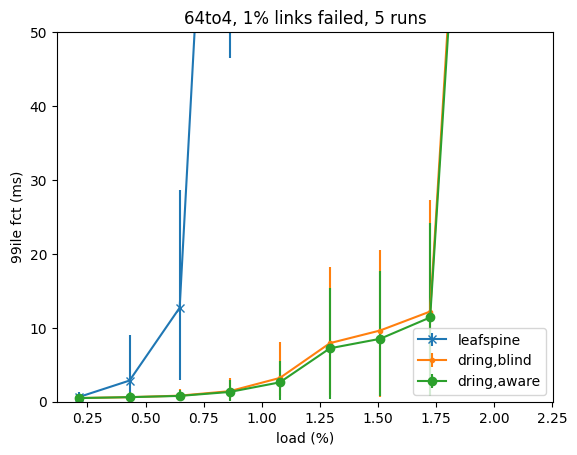

In [7]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

homedir = "/home/annzhou"
leafspinemultlistarr = [[0,69,320],[0,69,160],[0,207,320],[0,69,80]]
dringmultlistarr = [[0,69,320],[0,69,160],[0,207,320],[0,69,80],[1,5,64],[1,47,160],[1,163,320],[1,29,40],[1,301,320],[2,5,32]]
fseedarr = range(5)

xlist = list()
ylist_over_mult = list()
for multlist in leafspinemultlistarr:
    mult = multlist[0]
    numerator = multlist[1]
    denominator = multlist[2]

    xlist.append(mult + numerator/denominator)

    multname = f"{mult}_{numerator}_{denominator}"
    sumfile = f"{homedir}/DRing/src/emp/datacentre/experiments/linkfailure2/{multname}.txt"
    with open(sumfile,'r') as f:
        lines = f.readlines()
        fct_over_fseed = list()
        for fseed in fseedarr:
            logfile = f"m_linkfailure2_leafspine_ecmp_equal_{fseed}_0_{multname}.log"
            for line in lines:
                tokens = line.split()
                if tokens[0] == logfile:
                    n99fct = float(tokens[3])
                    fct_over_fseed.append(n99fct)
        ylist_over_mult.append(fct_over_fseed)
plt.errorbar(xlist,[sum(l)/len(l) for l in ylist_over_mult],yerr=[[min(l) for l in ylist_over_mult],[max(l) for l in ylist_over_mult]],label="leafspine",marker='x')

xlist = list()
ylist_over_mult = list()
for multlist in dringmultlistarr:
    mult = multlist[0]
    numerator = multlist[1]
    denominator = multlist[2]

    xlist.append(mult + numerator/denominator)

    multname = f"{mult}_{numerator}_{denominator}"
    sumfile = f"{homedir}/DRing/src/emp/datacentre/experiments/linkfailure2/{multname}.txt"
    with open(sumfile,'r') as f:
        lines = f.readlines()
        fct_over_fseed = list()
        for fseed in fseedarr:
            logfile = f"m_linkfailure2_dring_32disjoint_thisweight_{fseed}_0_{multname}.log"
            for line in lines:
                tokens = line.split()
                if tokens[0] == logfile:
                    n99fct = float(tokens[3])
                    fct_over_fseed.append(n99fct)
        ylist_over_mult.append(fct_over_fseed)
plt.errorbar(xlist,[sum(l)/len(l) for l in ylist_over_mult],yerr=[[min(l) for l in ylist_over_mult],[max(l) for l in ylist_over_mult]],label="dring,blind",marker='.')

xlist = list()
ylist_over_mult = list()
for multlist in dringmultlistarr:
    mult = multlist[0]
    numerator = multlist[1]
    denominator = multlist[2]

    xlist.append(mult + numerator/denominator)

    multname = f"{mult}_{numerator}_{denominator}"
    sumfile = f"{homedir}/DRing/src/emp/datacentre/experiments/linkfailure2/{multname}.txt"
    with open(sumfile,'r') as f:
        lines = f.readlines()
        fct_over_fseed = list()
        for fseed in fseedarr:
            logfile = f"m_linkfailure2_dring_32disjoint_thisweight_{fseed}_{fseed}_{multname}.log"
            for line in lines:
                tokens = line.split()
                if tokens[0] == logfile:
                    n99fct = float(tokens[3])
                    fct_over_fseed.append(n99fct)
        ylist_over_mult.append(fct_over_fseed)
plt.errorbar(xlist,[sum(l)/len(l) for l in ylist_over_mult],yerr=[[min(l) for l in ylist_over_mult],[max(l) for l in ylist_over_mult]],label="dring,aware",marker='o')

plt.legend()
plt.xlabel('load (%)')
plt.ylabel('99ile fct (ms)')
plt.title('64to4, 1% links failed, 5 runs')   
plt.ylim(0,50)      
plt.show()

delete

In [ ]:
import os

homedir = "/home/annzhou"
dringdir = f"{homedir}/DRing/src/emp/datacentre"
for filedir in os.listdir(dringdir):
    if os.path.isfile(os.path.join(dringdir, filedir)):
        tokens = filedir.split("_")
        if tokens[0]=="m" and tokens[1]=="linkfailure2" and tokens[-1].split('.')[-1]=="log":
            print(filedir)
            os.remove(f"{homedir}/DRing/src/emp/datacentre/{filedir}")
        if (tokens[0]=="rrg" or tokens[0]=="leafspine") and tokens[1]=="log":
            print(filedir)
            os.remove(f"{homedir}/DRing/src/emp/datacentre/{filedir}")
        if (tokens[-1]=="run") and ((tokens[0]=="leafspine" and tokens[1]=="leafspine") or (tokens[0]=="rrg" and (tokens[1]=="rrg" or tokens[1]=="dring"))):
            print(filedir)
            os.remove(f"{homedir}/DRing/src/emp/datacentre/{filedir}")